In [74]:
!pip install bokeh

In [0]:
%tensorflow_version 1.x
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import skimage.io as io
from keras.applications import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras import backend as K
from keras.utils import *
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.core.display import display
import os
import shutil
import re
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [3]:
cur_dir = Path.cwd()
mount_dir = cur_dir / 'drive'
drive.mount(str(mount_dir))

my_drive_dir = mount_dir / 'My Drive' / 'assignment_5'
with zipfile.ZipFile(my_drive_dir / 'hvc_data.zip', 'r') as f:
    f.extractall(cur_dir)

df = pd.read_csv('hvc_annotations.csv')
del df["filename"] # remove unwanted column
display(df)

# one hot encoding of labels
one_hot_df = pd.concat(
    [
        df[["image_path"]],
        pd.get_dummies(df.gender, prefix="gender"),
        pd.get_dummies(df.imagequality, prefix="imagequality"),
        pd.get_dummies(df.age, prefix="age"),
        pd.get_dummies(df.weight, prefix="weight"),
        pd.get_dummies(df.carryingbag, prefix="carryingbag"),
        pd.get_dummies(df.footwear, prefix="footwear"),
        pd.get_dummies(df.emotion, prefix="emotion"),
        pd.get_dummies(df.bodypose, prefix="bodypose"),
    ], 
    axis = 1
)
display(one_hot_df)

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 42)

print(train_df.shape, val_df.shape)
display(train_df)

class PersonDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = [
            items[_gender_cols_].values,
            items[_imagequality_cols_].values,
            items[_age_cols_].values,
            items[_weight_cols_].values,
            items[_carryingbag_cols_].values,
            items[_footwear_cols_].values,
            items[_bodypose_cols_].values,
            items[_emotion_cols_].values,
        ]
        
        return images, target

    def on_epoch_end(self):
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg
...,...,...,...,...,...,...,...,...,...
13568,male,Average,35-45,slightly-overweight,None,Normal,Happy,Front-Frontish,resized/13570.jpg
13569,female,Average,25-35,normal-healthy,Daily/Office/Work Bag,Fancy,Neutral,Front-Frontish,resized/13571.jpg
13570,female,Bad,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Side,resized/13572.jpg
13571,female,Bad,25-35,over-weight,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/13573.jpg


,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13568,resized/13570.jpg,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
13569,resized/13571.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
13570,resized/13572.jpg,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1
13571,resized/13573.jpg,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0


(11537, 28) (2036, 28)


,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6950,resized/6951.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
5035,resized/5036.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4410,resized/4411.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,resized/5192.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
13418,resized/13420.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
5390,resized/5391.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
860,resized/861.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [0]:
models_dir = my_drive_dir / 'models'
backup_models_dir = my_drive_dir / 'models.bak'
model_filename = str(models_dir / '{epoch}.hdf5')

def init_models_dir():
    if not models_dir.exists():
        models_dir.mkdir(parents=True)
        return
    shutil.rmtree(backup_models_dir, ignore_errors=True)
    shutil.move(models_dir, backup_models_dir)
    models_dir.mkdir(parents=True)

def load_best():
    return load_model(get_best())

def get_best():
    sessions = (i for i in models_dir.iterdir() if i.stem.isnumeric())
    return str(max(sessions, key=lambda i: int(i.stem)))    

def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies, losses

def get_random_eraser(p=1, w=25, h=25, v_l=0, v_h=1, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

def find_lr(model, start_lr, end_lr):
    finder = LRFinder(start_lr, end_lr, len(train_gen))
    weights = model.get_weights()    
    try:
        history = model.fit_generator(
            generator=train_gen,
            validation_data=valid_gen,
            epochs=1,
            verbose=1,
            callbacks=[finder],
        )   
    finally:    
        model.set_weights(weights)    
    return finder
    
class LRFinder(Callback):    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  

    def plot(self, lskip=10, rskip=10):
        lrs = self.lrs[lskip:-rskip]
        losses = self.smoothed_losses[lskip:-rskip]

        output_notebook()
        p = figure(title='Learning Rate Finder', x_axis_label='LR', y_axis_label='Loss')
        p.line(lrs, losses)
        show(p)
        
        best_idxs = np.argpartition(losses, 15)[:15]
        best_lrs = np.take(lrs, best_idxs)
        print(f"Best LRs: {best_lrs}")    

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            lr =  self.base_lr
        else:
            lr = self.clr()
        K.set_value(self.model.optimizer.lr, lr)        

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        lr = self.clr()
        K.set_value(self.model.optimizer.lr, lr)        

def plot_stats(hist_dict, lr_hist_dict):
    output_notebook() 

    # Plot LR

    p = figure(title='Learning Rate', x_axis_label='Iterations', y_axis_label='LR')

    y = lr_hist_dict['lr']
    x = lr_hist_dict['iterations']
    p.line(x, y, legend='LR')

    show(p)

    # Plot Loss

    p = figure(title='Overall Loss', x_axis_label='Epochs', y_axis_label='loss')

    y = hist_dict['loss']
    x = range(len(y))
    p.line(x, y, color='red', legend='Training')

    y = hist_dict['val_loss']
    x = range(len(y))
    p.line(x, y, color='blue', legend='Validation')

    show(p)

    # Plot accuracies

    for k, y in hist_dict.items():
        if not k.endswith('acc') or k.startswith('val'): 
            continue
        
        p = figure(title=k, x_axis_label='Epochs', y_axis_label='Accuracy')
        
        p.line(range(len(y)), y, color='red', legend='Training')
        p.line(range(len(y)), hist_dict[f'val_{k}'], color='blue', legend='Validataion')
        
        show(p)

In [0]:
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32,
    augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        shear_range=15,
        rotation_range=15,
        preprocessing_function=get_random_eraser(),
    )
)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)
for i in range(10):
    cv2_imshow(train_gen[0][0][i])












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 111, 111, 32) 155         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 111, 111, 32) 128         separable_conv2d_2[0][0]         
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 111, 111, 32) 0           batch_normalization_2[0][0]      
_________________________________________________________________________________

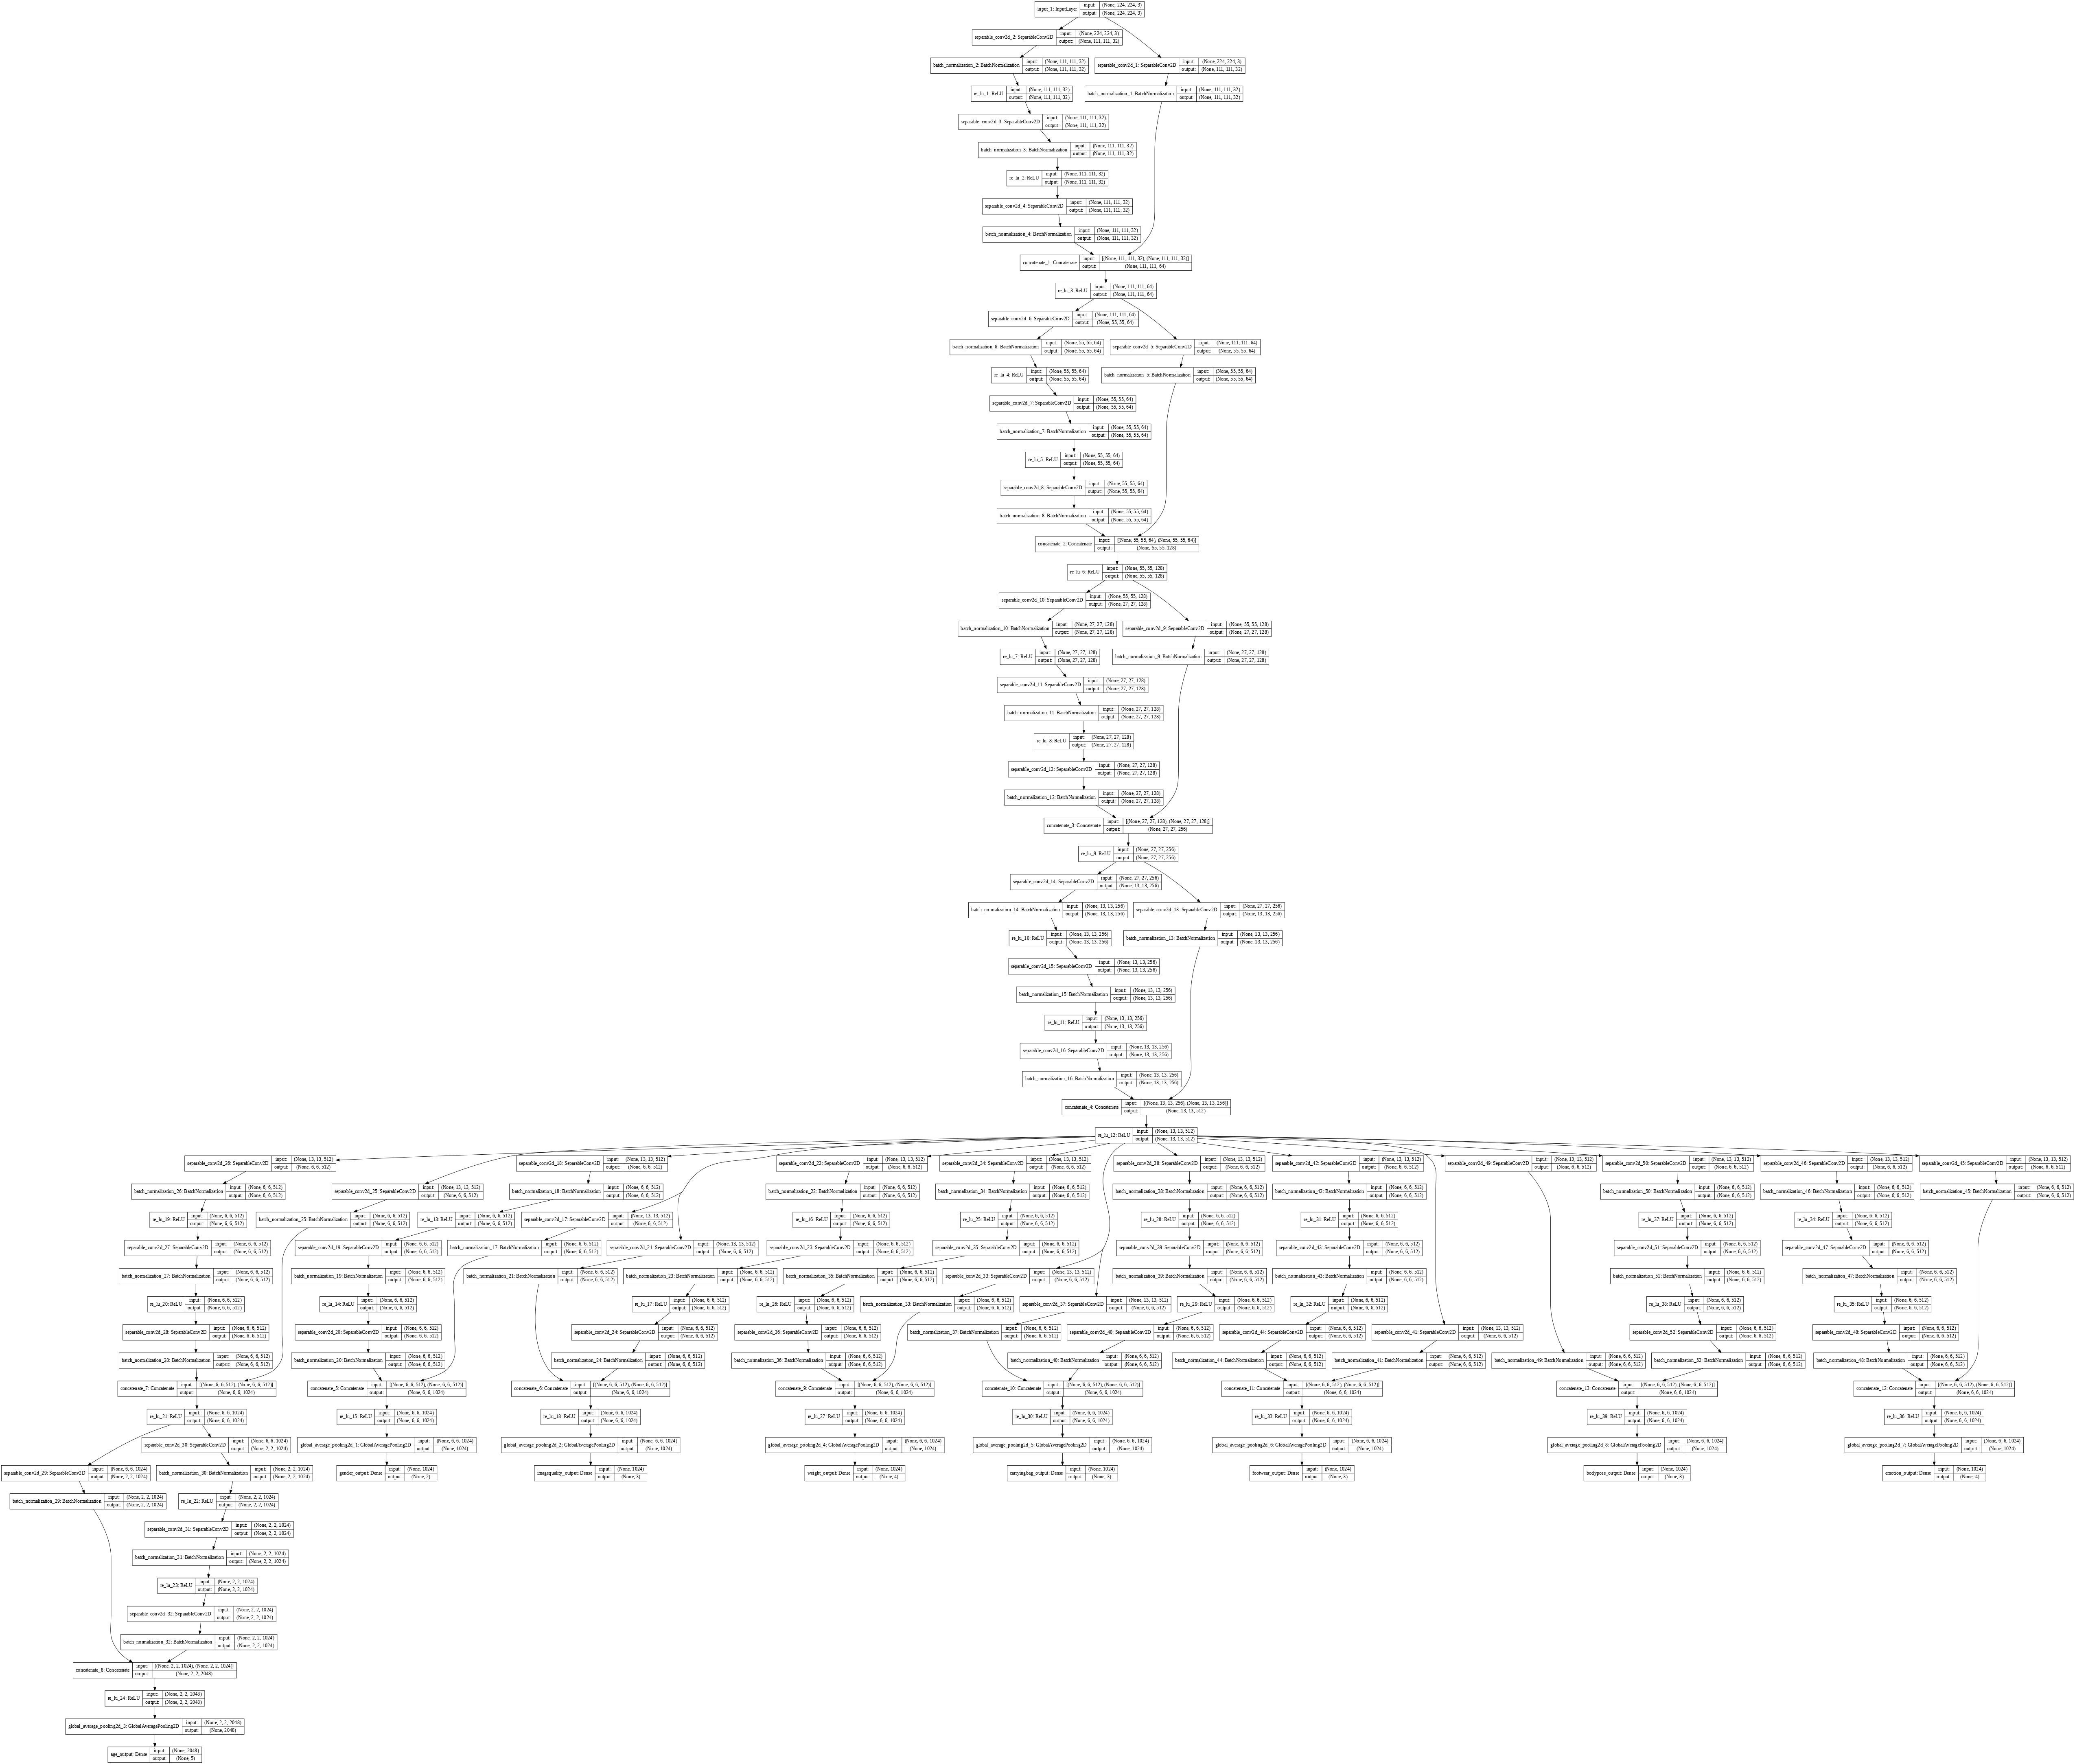

In [6]:
def build_head(name, x):
    x = GlobalAveragePooling2D()(x)
    x = Dense(len(df[name].unique()), activation="softmax", name=f"{name}_output")(x)
    return x

def bunch(f):
    def layer(x):
        y = SeparableConv2D(f, 3, strides=2)(x)
        y = BatchNormalization()(y)

        x = SeparableConv2D(f, 3, strides=2)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = SeparableConv2D(f, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = SeparableConv2D(f, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, y])

        x = ReLU()(x)

        return x
    return layer

inputs = x = Input(shape=(224,224, 3))
x = bunch(32)(x)
x = bunch(64)(x)
x = bunch(128)(x)
x = bunch(256)(x)

gender = build_head("gender", bunch(512)(x))
image_quality = build_head("imagequality", bunch(512)(x))
age = build_head("age", bunch(1024)(bunch(512)(x)))
weight = build_head("weight", bunch(512)(x))
bag = build_head("carryingbag", bunch(512)(x))
footwear = build_head("footwear", bunch(512)(x))
emotion = build_head("emotion", bunch(512)(x))
pose = build_head("bodypose", bunch(512)(x))

model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion],
)

model.summary()
plot_model(model, show_shapes=True, dpi=60)

Epoch 1/1
342/360 [===========================>..] - ETA: 6s - loss: 14.5022 - gender_output_loss: 1.2195 - imagequality_output_loss: 1.9834 - age_output_loss: 2.4269 - weight_output_loss: 1.5297 - carryingbag_output_loss: 1.7599 - footwear_output_loss: 1.9273 - bodypose_output_loss: 1.9980 - emotion_output_loss: 1.6576 - gender_output_acc: 0.4916 - imagequality_output_acc: 0.2976 - age_output_acc: 0.2823 - weight_output_acc: 0.6056 - carryingbag_output_acc: 0.4075 - footwear_output_acc: 0.4253 - bodypose_output_acc: 0.3585 - emotion_output_acc: 0.3810

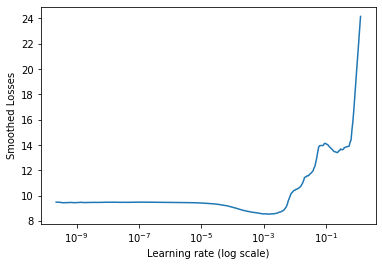

In [14]:
model.compile(
    optimizer=RMSprop(),
    loss="categorical_crossentropy", 
    metrics=['accuracy'],
)   
finder = find_lr(model, 1e-10, 10)
finder.plot()

Epoch 1/50
 - 131s - loss: 7.9979 - gender_output_loss: 0.6979 - imagequality_output_loss: 0.9900 - age_output_loss: 1.4548 - weight_output_loss: 1.0108 - carryingbag_output_loss: 0.9452 - footwear_output_loss: 1.0069 - bodypose_output_loss: 0.9545 - emotion_output_loss: 0.9376 - gender_output_acc: 0.5609 - imagequality_output_acc: 0.5353 - age_output_acc: 0.3836 - weight_output_acc: 0.6265 - carryingbag_output_acc: 0.5435 - footwear_output_acc: 0.5229 - bodypose_output_acc: 0.6082 - emotion_output_acc: 0.7099 - val_loss: 9.3518 - val_gender_output_loss: 0.6936 - val_imagequality_output_loss: 1.0895 - val_age_output_loss: 1.5981 - val_weight_output_loss: 1.3714 - val_carryingbag_output_loss: 1.0832 - val_footwear_output_loss: 1.0823 - val_bodypose_output_loss: 1.0706 - val_emotion_output_loss: 1.3630 - val_gender_output_acc: 0.4491 - val_imagequality_output_acc: 0.5660 - val_age_output_acc: 0.3866 - val_weight_output_acc: 0.6447 - val_carryingbag_output_acc: 0.5529 - val_footwear_outpu

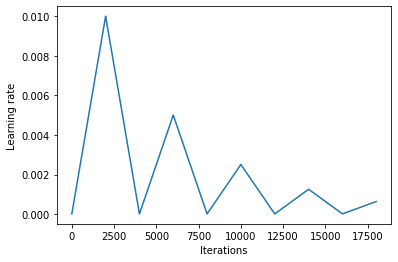

In [21]:
init_models_dir()
clr = CyclicLR(1e-5, 1e-2, mode='triangular2')
history = model.fit(
    x=train_gen,
    validation_data=valid_gen,
    epochs=50,
    verbose=2,
    callbacks=[
        ModelCheckpoint(model_filename, save_best_only=True, verbose=1),
        clr,
    ]
)

In [77]:
plot_stats(history.history, clr.history)

In [0]:
model = load_best()

In [157]:
model.compile(
    optimizer=SGD(),
    loss="categorical_crossentropy", 
    metrics=['accuracy'],
)  
finder = find_lr(model, 1e-10, 1e-1)
finder.plot()

Epoch 1/1
360/360 [==============================] - 137s 381ms/step - loss: 6.3884 - gender_output_loss: 0.3413 - imagequality_output_loss: 0.8528 - age_output_loss: 1.3236 - weight_output_loss: 0.9241 - carryingbag_output_loss: 0.8000 - footwear_output_loss: 0.7843 - bodypose_output_loss: 0.5116 - emotion_output_loss: 0.8510 - gender_output_acc: 0.8455 - imagequality_output_acc: 0.5955 - age_output_acc: 0.4234 - weight_output_acc: 0.6395 - carryingbag_output_acc: 0.6438 - footwear_output_acc: 0.6508 - bodypose_output_acc: 0.7916 - emotion_output_acc: 0.7135 - val_loss: 7.3635 - val_gender_output_loss: 0.5667 - val_imagequality_output_loss: 1.0884 - val_age_output_loss: 1.4284 - val_weight_output_loss: 0.9635 - val_carryingbag_output_loss: 0.8416 - val_footwear_output_loss: 0.8765 - val_bodypose_output_loss: 0.6872 - val_emotion_output_loss: 0.9112 - val_gender_output_acc: 0.7016 - val_imagequality_output_acc: 0.4607 - val_age_output_acc: 0.3785 - val_weight_output_acc: 0.6406 - val_c

Best LRs: [1.88364909e-10 1.77827941e-04 2.11348904e-10 1.99526231e-10
 1.67880402e-04 1.58489319e-04 1.49623566e-04 2.98538262e-04
 1.99526231e-04 1.88364909e-04 4.73151259e-05 2.37137371e-04
 2.11348904e-04 2.81838293e-04 1.41253754e-04]


In [158]:
init_models_dir()
clr = CyclicLR(1e-9, 1e-3, mode='triangular2')
history = model.fit(
    x=train_gen,
    validation_data=valid_gen,
    epochs=50,
    verbose=2,
    callbacks=[
        ModelCheckpoint(model_filename, save_best_only=True, verbose=1),
        clr,
    ]
)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.124000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.064660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 131s - loss: 6.3871 - gender_output_loss: 0.3472 - imagequality_output_loss: 0.8491 - age_output_loss: 1.3260 - weight_output_loss: 0.9240 - carryingbag_output_loss: 0.8002 - footwear_output_loss: 0.7814 - bodypose_output_loss: 0.5097 - emotion_output_loss: 0.8494 - gender_output_acc: 0.8443 - imagequality_output_acc: 0.5962 - age_output_acc: 0.4227 - weight_output_acc: 0.6412 - carryingbag_output_acc: 0.6450 - footwear_output_acc: 0.6489 - bodypose_output_acc: 0.7920 - emotion_output_acc: 0.7127 - val_loss: 6.6449 - val_gender_output_loss: 0.3462 - val_imagequality_output_loss: 0.9713 - val_age_output_loss: 1.3478 - val_weight_output_loss: 0.9414 - val_carryingbag_output_loss: 0.8074 - val_footwear_output_loss: 0.8061 - val_bodypose_output_loss: 0.5232 - val_emotion_output_loss: 0.9015 - val_gender_output_acc: 0.8528 - val_imagequality_output_acc: 0.5192 - val_age_output_acc: 0.4032 - val_weight_output_acc: 0.6431 - val_carryingbag_output_acc: 0.6482 - val_footwear_output_acc: 0.63

In [159]:
plot_stats(history.history, clr.history)    

In [0]:
model = load_best()

In [176]:
evaluate_model(model)

31/31 [==============================] - 11s 365ms/step


({'age_output_acc': 40.3226,
  'bodypose_output_acc': 81.5524,
  'carryingbag_output_acc': 64.9194,
  'emotion_output_acc': 70.5141,
  'footwear_output_acc': 63.5081,
  'gender_output_acc': 85.131,
  'imagequality_output_acc': 52.5706,
  'weight_output_acc': 64.2641},
 {'age_output_loss': 1.3472421053917176,
  'bodypose_output_loss': 0.5220625727407394,
  'carryingbag_output_loss': 0.8080068422902015,
  'emotion_output_loss': 0.9012841889935155,
  'footwear_output_loss': 0.8056276805939213,
  'gender_output_loss': 0.34679629629658115,
  'imagequality_output_loss': 0.9590740146175507,
  'loss': 6.631082473262664,
  'weight_output_loss': 0.9409886944678522})